<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/03-linear-classification/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic regression

In this seminar you will implement a logistic regression and train it using stochastic gradient descent modiffications, numpy and your brain.

In [ ]:
# !wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/03-linear-classification/dataset_scaled.pkl .
# !wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/03-linear-classification/dataset_not_scaled.pkl .

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Two-dimensional classification problem

To make things more intuitive, let's solve a 2D classification problem with syntetic data.

In [105]:
import pickle

with open("dataset_scaled.pkl", "rb") as f:
    X, y = pickle.load(f)

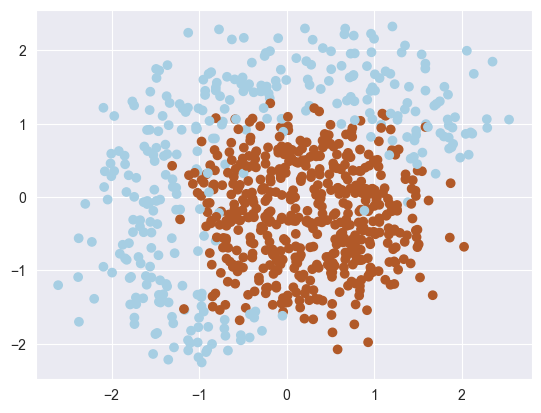

In [24]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [5]:
print(f"X[:3]:\n{X[:3]}\ny[:3]:\n{y[:3]}")

X[:3]:
[[-0.9698787  -1.31431435]
 [ 0.84830537 -0.43881443]
 [-1.52651763 -2.13810144]]
y[:3]:
[0 1 0]


**Your task starts here**

Since the problem above isn't linearly separable, we add quadratic features to the classifier.

Implement this transformation in the __expand__ function **(1 point)**. 

In [34]:
def expand(X):
    """
    Adds quadratic features. 
    This function allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature1*feature2, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_0 = X[:,0]
    X_1 = X[:,1]

    X_expanded = np.array([X_0, X_1, np.square(X_0), np.square(X_1), X_0 * X_1, np.ones(shape=X_0.shape)]).T
    X_expanded = np.stack([X_0, X_1, np.square(X_0), np.square(X_1), X_0 * X_1, np.ones(shape=X_0.shape)], axis=1)

    return X_expanded

In [35]:
#simple test on random numbers
#[all 8 random numbers are 100% random :P]
dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

#call your expand function
dummy_expanded = expand(dummy_X)
print(dummy_expanded.shape)
#what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])
print(dummy_expanded_ans.shape)
#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape==dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


(4, 6)
(4, 6)
Seems legit!


### Logistic regression
Now, let's write function `classify` that predicts class given X as in logistic regression **(1 point)**.

The math should look like this:

$$ P(y| \vec x, \vec w) = \sigma(\vec x \cdot \vec w )$$

where x represents features, w are weights and $$\sigma(a) = {1 \over {1+e^{-a}}}$$

We shall omit $ \vec {arrows} $ in further formulae for simplicity.

In [25]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

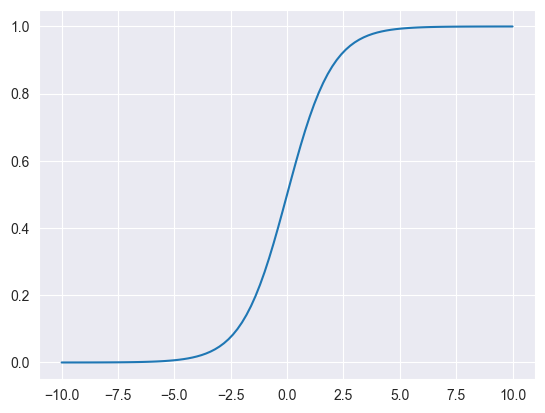

In [26]:
logits = np.linspace(-10, 10, 101)
plt.plot(logits, sigmoid(logits));

In [42]:
def classify(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    __don't forget to expand X inside classify and other functions__
    
    :param X: feature matrix X of shape [n_samples,2] (non-exanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """

    return sigmoid(expand(X) @ w.T)

In [44]:
#sample usage / test just as the previous one
dummy_weights = np.linspace(-1,1,6)

dummy_probs = classify(dummy_X,dummy_weights)

dummy_answers = np.array([ 0.73105858,  0.450166  ,  0.02020883,  0.59844257])

assert isinstance(dummy_probs,np.ndarray), "please return np.array"
assert dummy_probs.shape == dummy_answers.shape, "please return an 1-d vector with answers for each object"
assert np.allclose(dummy_probs,dummy_answers,1e-3), "There's something non-canonic about how probabilties are computed"

[0.73105858 0.450166   0.02020883 0.59844257]


The loss you should try to minimize is the Logistic Loss aka crossentropy aka negative log-likelihood:

$$ L =  - {1 \over N} \sum_i {y \cdot log P(y|x,w) + (1-y) \cdot log (1-P(y|x,w))}$$



Let's implement this loss inside compute_loss **(1 point)**.

In [57]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/0,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    return -np.average(y*np.log(classify(X, w)) + (1-y)*np.log(1-classify(X, w)))

In [59]:
dummy_y = np.array([0,1,0,1])
dummy_loss = compute_loss(dummy_X,dummy_y,dummy_weights)

assert np.allclose(dummy_loss,0.66131), "something wrong with loss"

Since we train our model with gradient descent, we gotta compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla L = {\partial L \over \partial w} = ...$$

No, we won't be giving you the exact formula this time. Instead, try figuring out a derivative with pen and paper and implement the `compute_grad` function **(3 point)**. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how L changes if you shift w by $10^-5$ or so).

In [70]:
def d_sigmoid(x):
    return np.exp(-x)/(1 + np.exp(-x)) ** 2

In [74]:
dummy_X

array([[ 0.  ,  0.  ],
       [ 1.  ,  0.  ],
       [ 2.61, -1.28],
       [-0.59,  2.1 ]])

In [73]:
d_sigmoid(expand(dummy_X) @ dummy_weights.T)

array([0.19661193, 0.24751657, 0.01980043, 0.24030906])

In [93]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    def d_sigmoid(x):
        return np.exp(-x)/(1 + np.exp(-x)) ** 2
    return np.mean((classify(X, w) - y)[:, None] * expand(X), axis=0)

In [94]:
#tests
dummy_grads = compute_grad(dummy_X,dummy_y,dummy_weights)
# dummy_X
#correct answers in canonic form
dummy_grads_ans = np.array([-0.06504252, -0.21728448, -0.1379879 , -0.43443953,  0.107504  , -0.05003101])
print(dummy_grads)
assert isinstance(dummy_grads,np.ndarray)
assert dummy_grads.shape == (6,), "must return a vector of gradients for each weight"
assert len(set(np.round(dummy_grads/dummy_grads_ans,3))), "gradients are wrong"
assert np.allclose(dummy_grads,dummy_grads_ans,1e-3), "gradients are off by a coefficient"

[-0.06504252 -0.21728448 -0.1379879  -0.43443953  0.107504   -0.05003101]


Here's an auxiliary function that visualizes the predictions

In [107]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, history):
    plt.figure(figsize=(12,6))
    """draws classifier prediction with matplotlib magic"""
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1,2,2)
    plt.plot(history)
    plt.grid()
    plt.ylabel("Loss")
    plt.xlabel("Iteration")
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

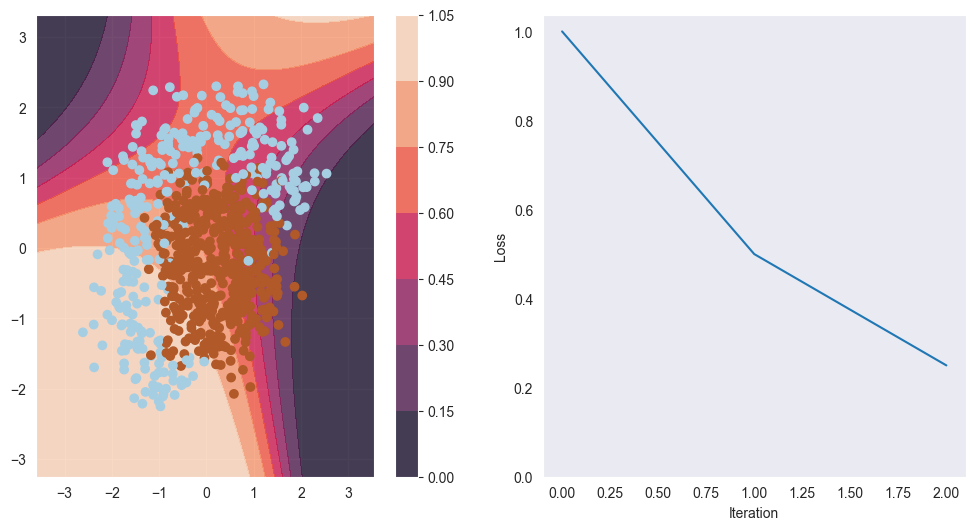

In [96]:
visualize(X, y, dummy_weights, [1, 0.5, 0.25],)

### Training
In this section, we'll use the functions you wrote to train our classifier using stochastic gradient descent.

Try to find an optimal learning rate for gradient descent for the given batch size. 

**Don't change the batch size!**

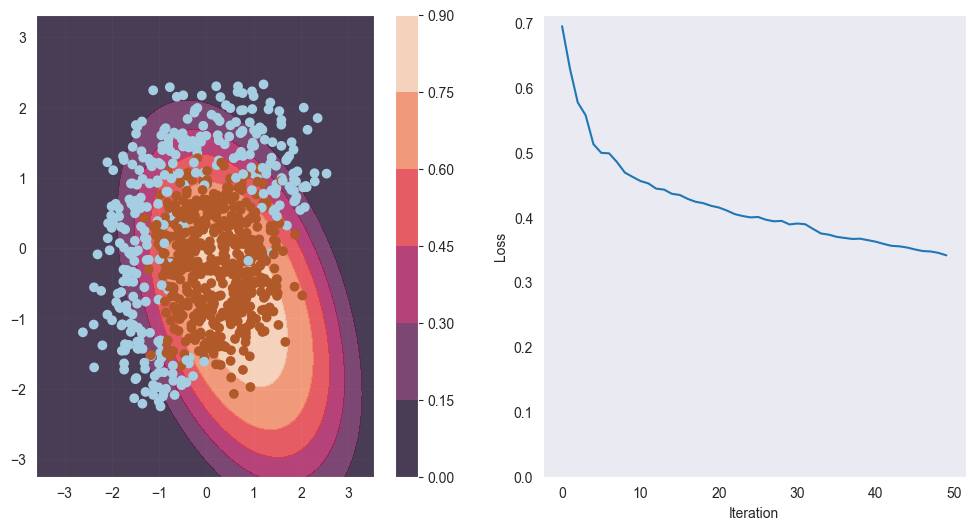

In [97]:
w = np.array([0,0,0,0,0,1])


alpha = 0.1

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

visualize(X, y, w, loss)

## Now, let's see what is happening, when we do not normalise features first.
## What do you think will happen?

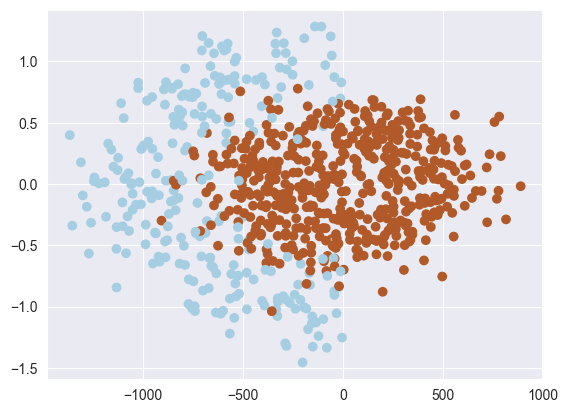

In [98]:
with open("dataset_not_scaled.pkl", "rb") as f:
    X, y = pickle.load(f)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [99]:
# Set parameters to show plots nicely
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 50), np.arange(y_min, y_max, h))

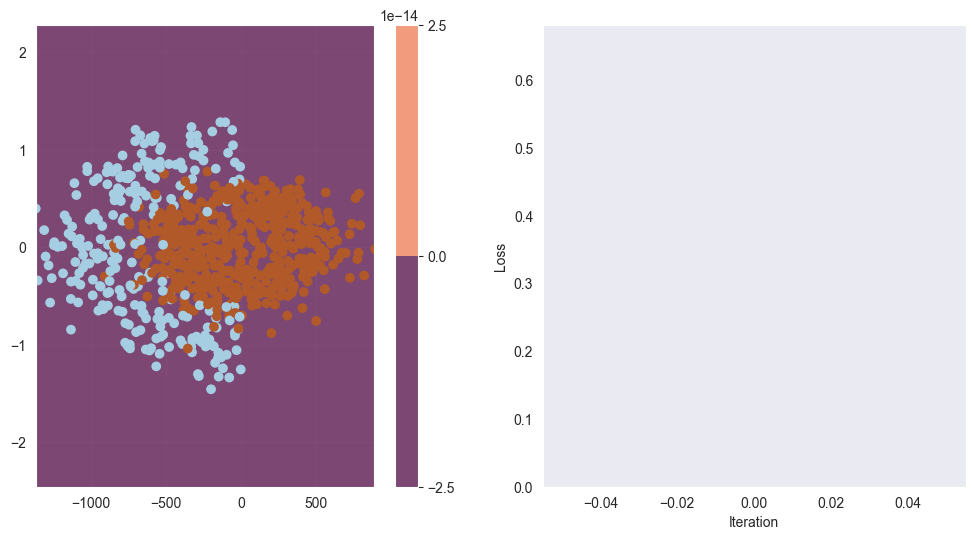

<Figure size 640x480 with 0 Axes>

In [100]:
w = np.array([0,0,0,0,0,1])


alpha = 0.0001

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

visualize(X, y, w, loss)
plt.clf()

In [101]:
loss

array([0.64659502,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

# Bonus quest 

If you're done and there's still time left, try implementing __momentum SGD__ as described [here](https://distill.pub/2017/momentum/).

Find alpha & beta that results in fastest convergence rate.

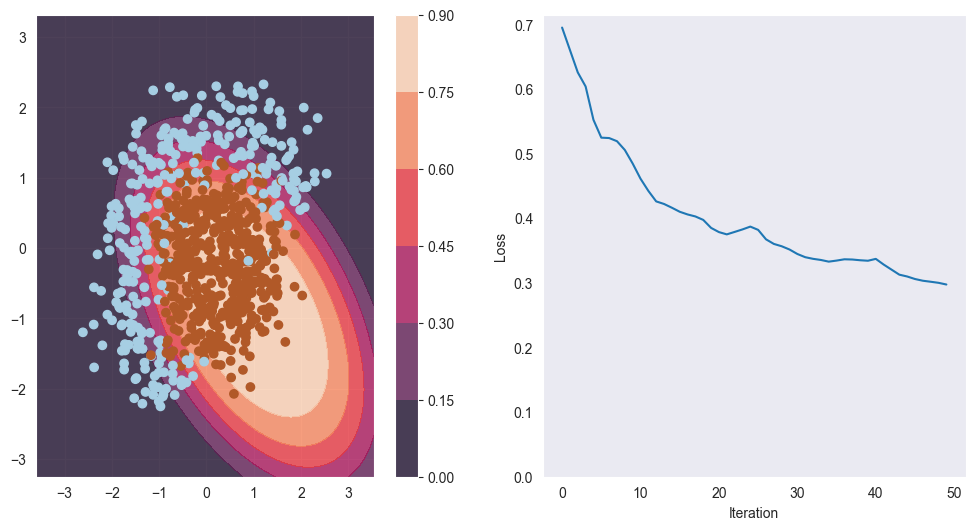

In [111]:
w = np.array([0,0,0,0,0,1])
z = np.array([0,0,0,0,0,0])

alpha = 0.1
beta = 0.8
grad = 0
n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X.shape[0], batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss)

    w = w - alpha * (beta * grad + compute_grad(X[ind,:], y[ind], w))
    grad = compute_grad(X[ind,:], y[ind], w)

visualize(X, y, w, loss)